In [1]:
from mxnet import nd, init, autograd
from mxnet.gluon import nn, data, loss, trainer
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
import time

In [2]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
X.shape, X.dtype, y

((28, 28, 1), numpy.uint8, 2)

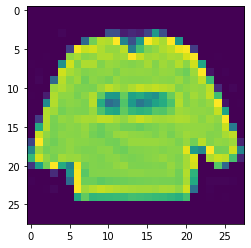

In [3]:
plt.imshow(X.reshape(28, 28).asnumpy())
plt.show()

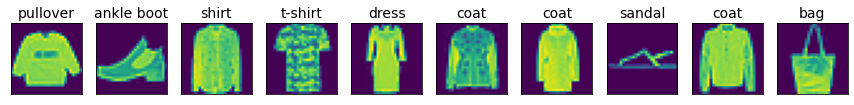

In [4]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[:10]

_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f, x, yi in zip(figs, X, y):
    f.imshow(x.reshape(28, 28).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)
])
mnist_train = mnist_train.transform_first(transformer)

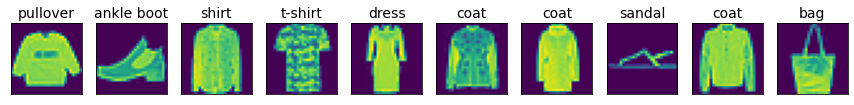

In [6]:
_, figs = plt.subplots(1, 10, figsize=(15, 15))

for f, x, yi in zip(figs, mnist_train[:10][0], mnist_train[:10][1]):
    f.imshow(x.reshape(28, 28).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
batch_size = 256
train_data = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
for X, y in train_data:
    print(X.shape, y.shape)
    break

(256, 1, 28, 28) (256,)


In [9]:
mnist_valid = datasets.FashionMNIST(train=False)
valid_data = data.DataLoader(mnist_valid.transform_first(transformer), batch_size=batch_size, num_workers=4)

In [10]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

In [11]:
softmax_cross_entropy = loss.SoftmaxCrossEntropyLoss()

In [12]:
optimizer = trainer.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [13]:
def acc(output: nd.NDArray, label: nd.NDArray) -> float:
    return (output.argmax(axis=1) == label.astype('float32')).mean().asscalar()

In [14]:
for epoch in range(1, 11):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for X, y in train_data:
        with autograd.record():
            output = net(X)
            ls = softmax_cross_entropy(output, y)
        ls.backward()
        optimizer.step(batch_size)
        train_loss += ls.mean().asscalar()
        train_acc += acc(output, y)
    for X, y in valid_data:
        valid_acc += acc(net(X), y)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (epoch, train_loss / len(train_data), train_acc / len(train_data), valid_acc / len(valid_data), time.time() - tic))


Epoch 1: loss 0.825, train acc 0.693, test acc 0.818, in 6.2 sec
Epoch 2: loss 0.475, train acc 0.821, test acc 0.855, in 3.0 sec
Epoch 3: loss 0.407, train acc 0.851, test acc 0.864, in 3.0 sec
Epoch 4: loss 0.364, train acc 0.865, test acc 0.877, in 3.0 sec
Epoch 5: loss 0.339, train acc 0.875, test acc 0.883, in 2.9 sec
Epoch 6: loss 0.321, train acc 0.882, test acc 0.885, in 2.9 sec
Epoch 7: loss 0.306, train acc 0.888, test acc 0.890, in 3.0 sec
Epoch 8: loss 0.295, train acc 0.891, test acc 0.886, in 2.9 sec
Epoch 9: loss 0.280, train acc 0.896, test acc 0.896, in 2.9 sec
Epoch 10: loss 0.272, train acc 0.900, test acc 0.891, in 2.9 sec


In [16]:
net.save_parameters('net.params')